In [1]:
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import sklearn.metrics
from sklearn.metrics import precision_score, f1_score, matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split

# LSTM model

In [17]:
class LSTMModel(nn.Module):
    """
    A PyTorch implementation of a Long Short-Term Memory (LSTM) model for time-series forecasting.
    """

    def __init__(self,
                 input_size,
                 hidden_size,
                 num_layers,
                 output_size,
                 dropout=0):

        super(LSTMModel, self).__init__()

        self.encoder = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )

        self.decoder = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )

        self.output_layer = nn.Linear(hidden_size, input_size)

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.dropout = dropout
        
    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        # Encode
        _, (hidden, cell) = self.encoder(x)

        # Prepare decoder input: repeat the encoded representation for each timestep
        # Use the last hidden state as the encoded representation
        encoded = hidden[-1].unsqueeze(1).repeat(1, seq_len, 1)  # Shape: (batch, seq_len, hidden_size)

        # Decode: Reconstruct the sequence
        decoder_output, _ = self.decoder(encoded, (hidden, cell))

        # Reconstruct
        reconstructed = self.output_layer(decoder_output)

        return reconstructed

    def get_reconstruction_error(self, x, loss):
        """Calculate reconstruction error for anomaly detection"""
        with torch.no_grad():
            reconstructed = self.forward(x)
            # Calculate MSE for each sequence
            mse =  loss(reconstructed, x).amax(dim=(1, 2)).cpu().numpy() #TODO check proper loss
            return mse.cpu().numpy()

    def encode(self, x):
        """Get the encoded representation of input sequences"""
        with torch.no_grad():
            _, (hidden, _) = self.encoder(x)
            return hidden[-1]  # Return the last layer's hidden state


# Configuration

In [18]:
DATA_PATH = "LSTM_preprocessed.parquet"
OUTPUT_DIR_AE = "models_per_route_lstm_ae"

In [19]:
FEATURE_COLUMNS = [ "speed_over_ground", "course_over_ground",
                    "latitude", "longitude", "draught",
                     # "dv"
                    ]


SEQUENCE_LENGTH = 10
SEQUENCE_STEP_LENGTH = 5

BATCH_SIZE = 32
VALIDATION_SIZE = 0.1

HIDDEN_SIZE = 32
NUM_LAYERS = 2

AUTOENCODER_THRESHOLD_PERCENTILE = 98

# Utils data

In [20]:
class Dataset:

    def __init__(self, df):
        self.df = df
        self.scaler = MinMaxScaler()


    def get_valid_trips(self, df):
        """
        Get trips that were actually labeled
        """

        df = df[df[FEATURE_COLUMNS].notna().all(axis=1) & df["y_true"].notna()]
        df = df.sort_values(['trip_id', 'time_stamp'])

        features_per_trip = df.groupby('trip_id')[FEATURE_COLUMNS].apply(lambda x: x.values.tolist()).reset_index()
        features_per_trip.columns = ["trip_id", "features"]

        labels_per_trip = df.groupby('trip_id')['y_true'].apply(list).reset_index()
        df = features_per_trip.merge(labels_per_trip, on='trip_id')
        return df


    def scale_sequences(self, sequences, fit=False):
        print(f"Scaling sequences with shape: {sequences.shape}")
        if fit:
            self.scaler.fit(sequences.reshape(-1, sequences.shape[-1]))

        transformed_sequences = self.scaler.transform(sequences.reshape(-1, sequences.shape[-1]))
        return transformed_sequences.reshape(sequences.shape)

    def create_sequences(self, df, seq_length):
        xs, ys, trip_ids = [], [], []
        for trip_id, group in df.groupby('trip_id'):
            features = np.concat(group["features"].values)
            labels = np.concat(group["y_true"].values)


            for i in range(0, len(labels) - seq_length - 1, SEQUENCE_STEP_LENGTH):
                seq_features = features[i:i+seq_length]
                seq_labels = labels[i:i+seq_length]

                if np.all(seq_labels > 0):
                    seq_label = 1
                else:
                    seq_label = 0

                # seq_label = int(np.sum(seq_labels) > (len(seq_labels) / 2))


                xs.append(seq_features)
                ys.append(seq_label)
                trip_ids.append(trip_id)
        return np.array(xs), np.array(ys), np.array(trip_ids)

    def separate_sequences_by_anomaly_type(self, sequences, labels):
        normal_sequences = sequences[labels == 0]
        anomaly_sequences = sequences[labels == 1]
        return normal_sequences, anomaly_sequences

    def get_loader(self, sequences, labels, batch_size, shuffle=True):
        sequences_tensor = torch.tensor(sequences, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.long)
        dataset = TensorDataset(sequences_tensor, labels_tensor)
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    def preprocess(self, df):
        df = self.get_valid_trips(df)
        sequences, labels, trip_ids = self.create_sequences(df, SEQUENCE_LENGTH)
        unique_trip_ids = np.unique(trip_ids)
        train_trips, val_trips = train_test_split(unique_trip_ids, test_size=VALIDATION_SIZE, random_state=42)

        train_X = sequences[np.isin(trip_ids, train_trips) & (labels == 0)]
        train_y = labels[np.isin(trip_ids, train_trips) & (labels == 0)]

        val_X = sequences[np.isin(trip_ids, val_trips) & (labels == 0)]
        val_y = labels[np.isin(trip_ids, val_trips) & (labels == 0)]

        anomaly_X = sequences[labels == 1]
        anomaly_labels = labels[labels == 1]

        train_X = self.scale_sequences(train_X, fit=True)
        val_X = self.scale_sequences(val_X)
        anomaly_X = self.scale_sequences(anomaly_X)

        print(f"Training normal sequences: {len(train_X)}")
        print(f"Validation normal sequences: {len(val_X)}")
        print(f"Anomaly sequences: {len(anomaly_X)}")

        train_loader = self.get_loader(train_X, train_y, BATCH_SIZE)
        val_loader = self.get_loader(val_X, val_y, BATCH_SIZE, shuffle=False)
        anomaly_loader = self.get_loader(anomaly_X, anomaly_labels, BATCH_SIZE, shuffle=False)

        return train_loader, val_loader, anomaly_loader

In [21]:
def load_data_route(route, datapath=DATA_PATH):
    """
    Load and prepare data for a specific route using new logic
    """
    df = pd.read_parquet(datapath)
    df.sort_values(['trip_id', 'time_stamp'], inplace=True)
    df_route = df[df['start_port'] == route].copy()

    print(f"Loaded {len(df_route)} data points for route {route}")
    print(f"Number of unique trips: {len(df_route['trip_id'].unique())}")

    return df_route

# Training utils

In [22]:
def verbous_metrics(val_labels, preds):
    m = get_all_metrics(val_labels,preds)
    verbose_metrics(m)
    return m

def get_all_metrics(true_labels, predictions):

    precision = precision_score(true_labels, predictions, zero_division=0)
    recall = recall_score(true_labels, predictions, zero_division=0)
    f1 = f1_score(true_labels, predictions, zero_division=0)

    tn = np.sum((true_labels == 0) & (predictions == 0))
    fp = np.sum((true_labels == 0) & (predictions == 1))
    fn = np.sum((true_labels == 1) & (predictions == 0))
    tp = np.sum((true_labels == 1) & (predictions == 1))

    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    mcc = matthews_corrcoef(true_labels, predictions)

    metrics = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'specificity': specificity,
        'true_positives': tp,
        'true_negatives': tn,
        'false_positives': fp,
        'false_negatives': fn,
        'mcc': mcc,
        'unlabeled_sequences': np.sum(true_labels == -1),
    }
    return metrics

def verbose_metrics(metrics):
    print("Evaluation Metrics:")
    for key, value in metrics.items():
        if (value != 0 and value != 1):
            print(f"{key.replace('_', ' ').title()}: {value:.4f}")


In [23]:
def validation(model,
               val_loader,
               loss,
               device,
               threshold = 0,
               validate = True
               ):

    errors = []
    val_labels = []

    with torch.no_grad():
        for val_X, val_y in val_loader:  # Only normal samples
            val_X = val_X.to(device)
            reconstructed = model(val_X)

            # Save per-sequence max error
            batch_errors = loss(reconstructed, val_X).amax(dim=(1, 2)).cpu().numpy()
            errors.extend(batch_errors)
            val_labels.extend(val_y.cpu().numpy())

    if validate:
        # Calculate threshold based on validation data
        threshold = np.percentile(errors, AUTOENCODER_THRESHOLD_PERCENTILE)
        print(f"Validation threshold: {threshold:.6f}")

    preds = (np.array(errors) > threshold).astype(int)
    m = verbous_metrics(val_labels,preds)
  
    return errors, preds, threshold, m

In [24]:
from tqdm import tqdm
import sklearn
from torch.utils.data import ConcatDataset, DataLoader
import copy
from torch.optim.lr_scheduler import StepLR

def train(model,
          train_loader, val_loader, anomaly_loader,
          optimizer,
          loss,
          device,
          EPOCHS=20):

    # scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
    
    best_mcc = -1
    best_model_state = None
    best_threshold = 0
    
    for epoch in range(EPOCHS):
        loss_history = []

        # ----- Training Loop -----
        model.train()
        for batch_X, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            batch_X = batch_X.to(device)

            optimizer.zero_grad()

            noise = torch.randn_like(batch_X) * 0.1 # NEW
            noisy_input = batch_X + noise
            
            out = model(noisy_input)
            batch_loss = loss(out, batch_X).mean()

            loss_history.append(batch_loss.item())
            batch_loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()

        print(f"Training loss: {np.mean(loss_history):.6f}")

        # ----- Validation on NORMAL data (for threshold calculation) -----
        model.eval()
        print("====Val")
        normal_errors, _, threshold, metr_v = validation(model, val_loader, loss, device)
        print("====Anom")
        anomaly_errors, _, _, metr_a = validation(model, anomaly_loader, loss, device, threshold=threshold, validate=False)
        print("====Comb")

        combined_dataset = ConcatDataset([val_loader.dataset, anomaly_loader.dataset])
        combined_loader = DataLoader(combined_dataset, batch_size=val_loader.batch_size, shuffle=False)
        com_errors, _, _, metr_c = validation(model, combined_loader, loss, device, threshold=threshold, validate=False)

        mcc = metr_c.get('mcc')
        if mcc > best_mcc:
            best_mcc = mcc
            best_model_state = copy.deepcopy(model.state_dict())
            best_threshold = threshold
            print("Best model updated.")

        # if scheduler: 
            # scheduler.step()
            
    metrics_final = []
    
    if best_model_state is not None:
        print(f"Best model with mcc {best_mcc}")
        model.load_state_dict(best_model_state)
        
        combined_dataset = ConcatDataset([val_loader.dataset, anomaly_loader.dataset])
        combined_loader = DataLoader(combined_dataset, batch_size=val_loader.batch_size, shuffle=False)
        com_errors, _, _, metrics_final = validation(model, combined_loader, loss, device, threshold=best_threshold, validate=False)
        

    return normal_errors, anomaly_errors, metrics_final

## Plotting

In [25]:
import matplotlib.pyplot as plt

def plot_errors(normal_errors, anomaly_errors):

    plt.hist(normal_errors, bins=100, alpha=0.5, label="Normal")
    plt.hist(anomaly_errors, bins=100, alpha=0.5, label="Anomaly")
    # plt.axvline(thresh[best_idx], color="red", linestyle="--", label="Best Threshold")
    plt.yscale("log")
    plt.legend()
    plt.title("Reconstruction Error Distribution (log scale)")
    plt.xlabel("Max Reconstruction Error")
    plt.ylabel("Log Count")
    plt.grid(True)
    plt.show()

def plot_boxplot(normal_errors, anomaly_errors):
    plt.figure(figsize=(12, 6))

    error_data = [normal_errors, anomaly_errors]
    plt.boxplot(error_data, labels=['Normal', 'Anomaly'])
    plt.ylabel('Reconstruction Error')
    plt.title('Reconstruction Error Distribution')
    plt.grid(True, alpha=0.3)
    plt.show()

# Loading data

## Kiel

In [26]:
df_KIEL = load_data_route("KIEL")
dataset_KIEL = Dataset(df_KIEL)

Loaded 534244 data points for route KIEL
Number of unique trips: 420


In [27]:
train_loader_K, val_loader_K, anomaly_loader_K = dataset_KIEL.preprocess(df_KIEL)

Scaling sequences with shape: (13561, 10, 5)
Scaling sequences with shape: (1793, 10, 5)
Scaling sequences with shape: (611, 10, 5)
Training normal sequences: 13561
Validation normal sequences: 1793
Anomaly sequences: 611


## Bremenhaven

In [28]:
df_BREM = load_data_route("BREMERHAVEN")
dataset_BREM = Dataset(df_BREM)

Loaded 378322 data points for route BREMERHAVEN
Number of unique trips: 703


In [29]:
train_loader_B, val_loader_B, anomaly_loader_B = dataset_BREM.preprocess(df_BREM)

Scaling sequences with shape: (4434, 10, 5)
Scaling sequences with shape: (618, 10, 5)
Scaling sequences with shape: (127, 10, 5)
Training normal sequences: 4434
Validation normal sequences: 618
Anomaly sequences: 127


# Training

## KIEL

In [32]:
model_K = LSTMModel(
    input_size=len(FEATURE_COLUMNS),
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    output_size=len(FEATURE_COLUMNS),
    dropout=0.4
)

optimizer_K = torch.optim.AdamW(model_K.parameters(), lr=0.005, weight_decay=1e-3)
loss_K = nn.MSELoss(reduction='none') 
# loss_B = nn.HuberLoss(reduction='none', delta = 0.3) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_K = model_K.to(device)

AUTOENCODER_THRESHOLD_PERCENTILE = 98

In [33]:
normal_errors_K, anomaly_errors_K, metrics_K = train(model_K,
        train_loader_K, val_loader_K, anomaly_loader_K,
          optimizer_K,
          loss_K,
          device,
          EPOCHS=20)

Epoch 1/20: 100%|██████████| 424/424 [00:02<00:00, 208.03it/s]


Training loss: 0.015042
====Val
Validation threshold: 0.048647
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.6743
F1: 0.8055
====Comb
Evaluation Metrics:
Precision: 0.9196
Recall: 0.6743
F1: 0.7781
Mcc: 0.7315
Best model updated.


Epoch 2/20: 100%|██████████| 424/424 [00:02<00:00, 206.33it/s]


Training loss: 0.002496
====Val
Validation threshold: 0.028333
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.6563
F1: 0.7925
====Comb
Evaluation Metrics:
Precision: 0.9176
Recall: 0.6563
F1: 0.7653
Mcc: 0.7183


Epoch 3/20: 100%|██████████| 424/424 [00:02<00:00, 200.86it/s]


Training loss: 0.001829
====Val
Validation threshold: 0.025506
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.6448
F1: 0.7841
====Comb
Evaluation Metrics:
Precision: 0.9163
Recall: 0.6448
F1: 0.7570
Mcc: 0.7098


Epoch 4/20: 100%|██████████| 424/424 [00:02<00:00, 204.55it/s]


Training loss: 0.001691
====Val
Validation threshold: 0.024883
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.6530
F1: 0.7901
====Comb
Evaluation Metrics:
Precision: 0.9172
Recall: 0.6530
F1: 0.7629
Mcc: 0.7158


Epoch 5/20: 100%|██████████| 424/424 [00:02<00:00, 206.09it/s]


Training loss: 0.001594
====Val
Validation threshold: 0.026463
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.6547
F1: 0.7913
====Comb
Evaluation Metrics:
Precision: 0.9174
Recall: 0.6547
F1: 0.7641
Mcc: 0.7170


Epoch 6/20: 100%|██████████| 424/424 [00:02<00:00, 195.49it/s]


Training loss: 0.001565
====Val
Validation threshold: 0.025520
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.5908
F1: 0.7428
====Comb
Evaluation Metrics:
Precision: 0.9093
Recall: 0.5908
F1: 0.7163
Mcc: 0.6693


Epoch 7/20: 100%|██████████| 424/424 [00:02<00:00, 192.48it/s]


Training loss: 0.001476
====Val
Validation threshold: 0.019864
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.6547
F1: 0.7913
====Comb
Evaluation Metrics:
Precision: 0.9174
Recall: 0.6547
F1: 0.7641
Mcc: 0.7170


Epoch 8/20: 100%|██████████| 424/424 [00:02<00:00, 188.31it/s]


Training loss: 0.001408
====Val
Validation threshold: 0.018791
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.7005
F1: 0.8239
====Comb
Evaluation Metrics:
Precision: 0.9224
Recall: 0.7005
F1: 0.7963
Mcc: 0.7506
Best model updated.


Epoch 9/20: 100%|██████████| 424/424 [00:02<00:00, 188.35it/s]


Training loss: 0.001400
====Val
Validation threshold: 0.018857
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.7512
F1: 0.8579
====Comb
Evaluation Metrics:
Precision: 0.9273
Recall: 0.7512
F1: 0.8300
Mcc: 0.7872
Best model updated.


Epoch 10/20: 100%|██████████| 424/424 [00:02<00:00, 194.52it/s]


Training loss: 0.001342
====Val
Validation threshold: 0.019358
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.7185
F1: 0.8362
====Comb
Evaluation Metrics:
Precision: 0.9242
Recall: 0.7185
F1: 0.8085
Mcc: 0.7637


Epoch 11/20: 100%|██████████| 424/424 [00:02<00:00, 186.80it/s]


Training loss: 0.001315
====Val
Validation threshold: 0.016486
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.7610
F1: 0.8643
====Comb
Evaluation Metrics:
Precision: 0.9281
Recall: 0.7610
F1: 0.8363
Mcc: 0.7943
Best model updated.


Epoch 12/20: 100%|██████████| 424/424 [00:02<00:00, 187.07it/s]


Training loss: 0.001293
====Val
Validation threshold: 0.017910
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.7169
F1: 0.8351
====Comb
Evaluation Metrics:
Precision: 0.9241
Recall: 0.7169
F1: 0.8074
Mcc: 0.7625


Epoch 13/20: 100%|██████████| 424/424 [00:02<00:00, 184.73it/s]


Training loss: 0.001293
====Val
Validation threshold: 0.015727
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.8020
F1: 0.8901
====Comb
Evaluation Metrics:
Precision: 0.9316
Recall: 0.8020
F1: 0.8619
Mcc: 0.8234
Best model updated.


Epoch 14/20: 100%|██████████| 424/424 [00:02<00:00, 172.32it/s]


Training loss: 0.001232
====Val
Validation threshold: 0.016284
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.7381
F1: 0.8493
====Comb
Evaluation Metrics:
Precision: 0.9261
Recall: 0.7381
F1: 0.8215
Mcc: 0.7778


Epoch 15/20: 100%|██████████| 424/424 [00:02<00:00, 177.77it/s]


Training loss: 0.001204
====Val
Validation threshold: 0.019156
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.7201
F1: 0.8373
====Comb
Evaluation Metrics:
Precision: 0.9244
Recall: 0.7201
F1: 0.8096
Mcc: 0.7649


Epoch 16/20: 100%|██████████| 424/424 [00:02<00:00, 186.13it/s]


Training loss: 0.001206
====Val
Validation threshold: 0.016844
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.8151
F1: 0.8981
====Comb
Evaluation Metrics:
Precision: 0.9326
Recall: 0.8151
F1: 0.8699
Mcc: 0.8327
Best model updated.


Epoch 17/20: 100%|██████████| 424/424 [00:02<00:00, 203.39it/s]


Training loss: 0.001245
====Val
Validation threshold: 0.016159
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.6874
F1: 0.8147
====Comb
Evaluation Metrics:
Precision: 0.9211
Recall: 0.6874
F1: 0.7873
Mcc: 0.7411


Epoch 18/20: 100%|██████████| 424/424 [00:02<00:00, 179.28it/s]


Training loss: 0.001142
====Val
Validation threshold: 0.016607
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.7152
F1: 0.8340
====Comb
Evaluation Metrics:
Precision: 0.9239
Recall: 0.7152
F1: 0.8063
Mcc: 0.7613


Epoch 19/20: 100%|██████████| 424/424 [00:02<00:00, 167.29it/s]


Training loss: 0.001149
====Val
Validation threshold: 0.017616
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.8412
F1: 0.9138
====Comb
Evaluation Metrics:
Precision: 0.9345
Recall: 0.8412
F1: 0.8854
Mcc: 0.8511
Best model updated.


Epoch 20/20: 100%|██████████| 424/424 [00:02<00:00, 177.56it/s]


Training loss: 0.001165
====Val
Validation threshold: 0.015418
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.7234
F1: 0.8395
====Comb
Evaluation Metrics:
Precision: 0.9247
Recall: 0.7234
F1: 0.8118
Mcc: 0.7672
Best model with mcc 0.8511485895035088
Evaluation Metrics:
Precision: 0.9345
Recall: 0.8412
F1: 0.8854
Mcc: 0.8511


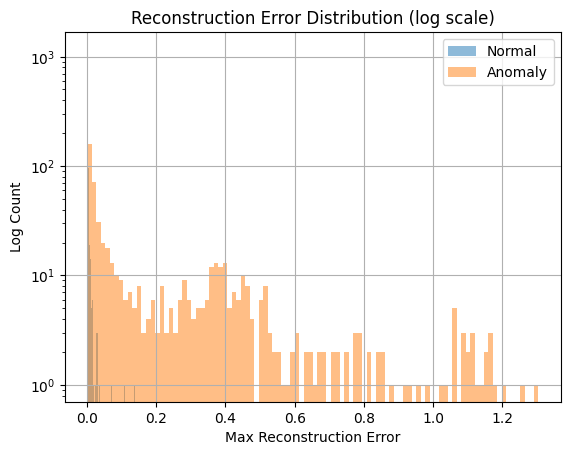

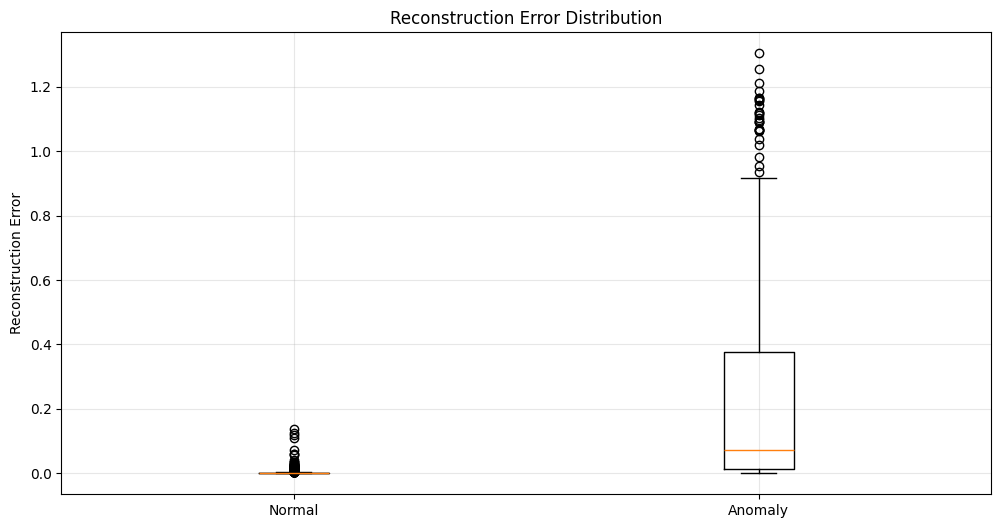

In [34]:
plot_errors(normal_errors_K, anomaly_errors_K )
plot_boxplot(normal_errors_K, anomaly_errors_K )

## BREMERHAVEN

In [35]:
model_B = LSTMModel(
    input_size=len(FEATURE_COLUMNS),
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    output_size=len(FEATURE_COLUMNS),
    dropout=0.1
)

optimizer_B = torch.optim.AdamW(model_B.parameters(), lr=0.0001, weight_decay=1e-3)
loss_B = nn.HuberLoss(reduction='none', delta = 0.1) 
# loss_B = nn.MSELoss(reduction='none') 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_B = model_B.to(device)

AUTOENCODER_THRESHOLD_PERCENTILE = 90

In [36]:
normal_errors_B, anomaly_errors_B, metrics_B = train(model_B,
        train_loader_B, val_loader_B, anomaly_loader_B,
          optimizer_B,
          loss_B,
          device,
          EPOCHS=20)

Epoch 1/20: 100%|██████████| 139/139 [00:00<00:00, 190.34it/s]


Training loss: 0.051257
====Val
Validation threshold: 0.084939
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.4016
F1: 0.5730
====Comb
Evaluation Metrics:
Precision: 0.4554
Recall: 0.4016
F1: 0.4268
Mcc: 0.3187
Best model updated.


Epoch 2/20: 100%|██████████| 139/139 [00:00<00:00, 200.27it/s]


Training loss: 0.018873
====Val
Validation threshold: 0.053844
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.2283
F1: 0.3718
====Comb
Evaluation Metrics:
Precision: 0.3187
Recall: 0.2283
F1: 0.2661
Mcc: 0.1470


Epoch 3/20: 100%|██████████| 139/139 [00:00<00:00, 220.92it/s]


Training loss: 0.014137
====Val
Validation threshold: 0.050902
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.2992
F1: 0.4606
====Comb
Evaluation Metrics:
Precision: 0.3800
Recall: 0.2992
F1: 0.3348
Mcc: 0.2194


Epoch 4/20: 100%|██████████| 139/139 [00:00<00:00, 192.04it/s]


Training loss: 0.013907
====Val
Validation threshold: 0.052309
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.2441
F1: 0.3924
====Comb
Evaluation Metrics:
Precision: 0.3333
Recall: 0.2441
F1: 0.2818
Mcc: 0.1636


Epoch 5/20: 100%|██████████| 139/139 [00:00<00:00, 183.06it/s]


Training loss: 0.013642
====Val
Validation threshold: 0.052445
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.1575
F1: 0.2721
====Comb
Evaluation Metrics:
Precision: 0.2439
Recall: 0.1575
F1: 0.1914
Mcc: 0.0687


Epoch 6/20: 100%|██████████| 139/139 [00:00<00:00, 206.46it/s]


Training loss: 0.013122
====Val
Validation threshold: 0.049409
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.1890
F1: 0.3179
====Comb
Evaluation Metrics:
Precision: 0.2791
Recall: 0.1890
F1: 0.2254
Mcc: 0.1043


Epoch 7/20: 100%|██████████| 139/139 [00:00<00:00, 217.79it/s]


Training loss: 0.011081
====Val
Validation threshold: 0.042021
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.5197
F1: 0.6839
====Comb
Evaluation Metrics:
Precision: 0.5156
Recall: 0.5197
F1: 0.5176
Mcc: 0.4181
Best model updated.


Epoch 8/20: 100%|██████████| 139/139 [00:00<00:00, 218.37it/s]


Training loss: 0.007836
====Val
Validation threshold: 0.032612
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.7638
F1: 0.8661
====Comb
Evaluation Metrics:
Precision: 0.6139
Recall: 0.7638
F1: 0.6807
Mcc: 0.6118
Best model updated.


Epoch 9/20: 100%|██████████| 139/139 [00:00<00:00, 192.24it/s]


Training loss: 0.004832
====Val
Validation threshold: 0.021318
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.9291
F1: 0.9633
====Comb
Evaluation Metrics:
Precision: 0.6556
Recall: 0.9291
F1: 0.7687
Mcc: 0.7281
Best model updated.


Epoch 10/20: 100%|██████████| 139/139 [00:00<00:00, 190.31it/s]


Training loss: 0.003995
====Val
Validation threshold: 0.018421
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.9370
F1: 0.9675
====Comb
Evaluation Metrics:
Precision: 0.6575
Recall: 0.9370
F1: 0.7727
Mcc: 0.7336
Best model updated.


Epoch 11/20: 100%|██████████| 139/139 [00:00<00:00, 234.02it/s]


Training loss: 0.003703
====Val
Validation threshold: 0.015768
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.9606
F1: 0.9799
====Comb
Evaluation Metrics:
Precision: 0.6630
Recall: 0.9606
F1: 0.7846
Mcc: 0.7502
Best model updated.


Epoch 12/20: 100%|██████████| 139/139 [00:00<00:00, 214.34it/s]


Training loss: 0.003468
====Val
Validation threshold: 0.013674
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.9528
F1: 0.9758
====Comb
Evaluation Metrics:
Precision: 0.6648
Recall: 0.9528
F1: 0.7832
Mcc: 0.7475


Epoch 13/20: 100%|██████████| 139/139 [00:00<00:00, 197.19it/s]


Training loss: 0.003261
====Val
Validation threshold: 0.013644
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.9528
F1: 0.9758
====Comb
Evaluation Metrics:
Precision: 0.6648
Recall: 0.9528
F1: 0.7832
Mcc: 0.7475


Epoch 14/20: 100%|██████████| 139/139 [00:00<00:00, 171.70it/s]


Training loss: 0.003117
====Val
Validation threshold: 0.013144
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.9528
F1: 0.9758
====Comb
Evaluation Metrics:
Precision: 0.6612
Recall: 0.9528
F1: 0.7806
Mcc: 0.7447


Epoch 15/20: 100%|██████████| 139/139 [00:00<00:00, 196.30it/s]


Training loss: 0.002975
====Val
Validation threshold: 0.013495
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.9134
F1: 0.9547
====Comb
Evaluation Metrics:
Precision: 0.6517
Recall: 0.9134
F1: 0.7607
Mcc: 0.7170


Epoch 16/20: 100%|██████████| 139/139 [00:00<00:00, 193.31it/s]


Training loss: 0.002870
====Val
Validation threshold: 0.012423
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.9291
F1: 0.9633
====Comb
Evaluation Metrics:
Precision: 0.6592
Recall: 0.9291
F1: 0.7712
Mcc: 0.7309


Epoch 17/20: 100%|██████████| 139/139 [00:00<00:00, 202.39it/s]


Training loss: 0.002751
====Val
Validation threshold: 0.012604
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.9134
F1: 0.9547
====Comb
Evaluation Metrics:
Precision: 0.6517
Recall: 0.9134
F1: 0.7607
Mcc: 0.7170


Epoch 18/20: 100%|██████████| 139/139 [00:00<00:00, 179.83it/s]


Training loss: 0.002574
====Val
Validation threshold: 0.010837
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.9370
F1: 0.9675
====Comb
Evaluation Metrics:
Precision: 0.6575
Recall: 0.9370
F1: 0.7727
Mcc: 0.7336


Epoch 19/20: 100%|██████████| 139/139 [00:00<00:00, 195.59it/s]


Training loss: 0.002317
====Val
Validation threshold: 0.010836
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.9213
F1: 0.9590
====Comb
Evaluation Metrics:
Precision: 0.6536
Recall: 0.9213
F1: 0.7647
Mcc: 0.7226


Epoch 20/20: 100%|██████████| 139/139 [00:00<00:00, 192.94it/s]


Training loss: 0.002000
====Val
Validation threshold: 0.010189
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.9213
F1: 0.9590
====Comb
Evaluation Metrics:
Precision: 0.6536
Recall: 0.9213
F1: 0.7647
Mcc: 0.7226
Best model with mcc 0.7501685578973611
Evaluation Metrics:
Precision: 0.6630
Recall: 0.9606
F1: 0.7846
Mcc: 0.7502


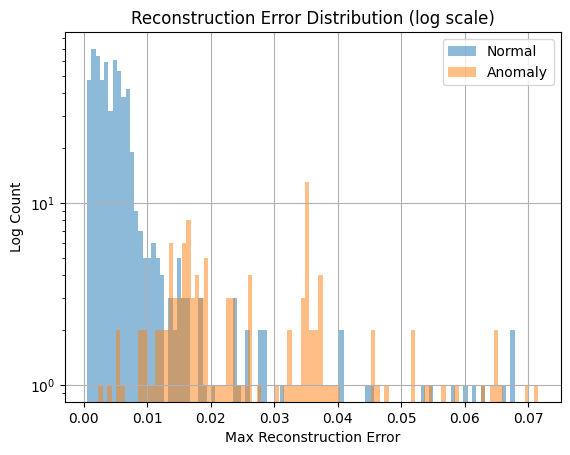

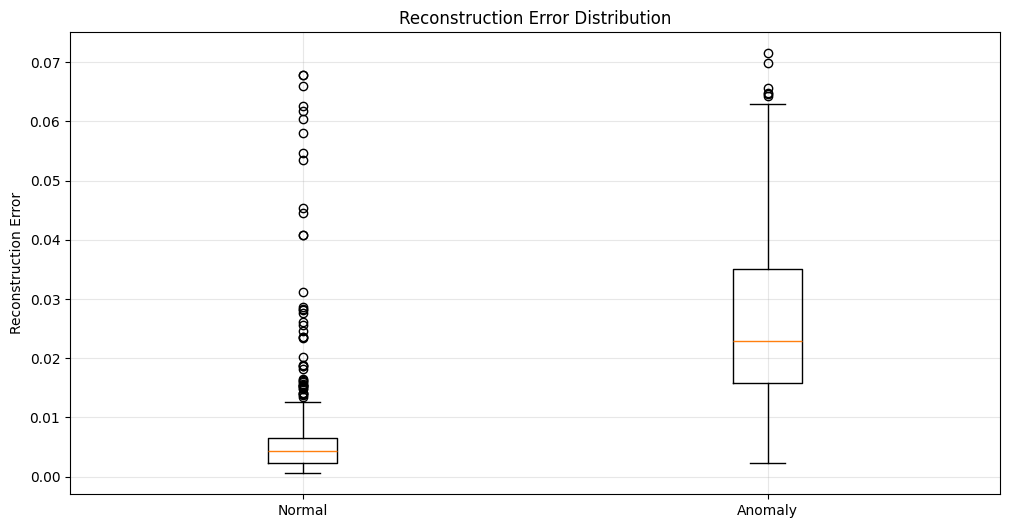

In [37]:
plot_errors(normal_errors_B, anomaly_errors_B)
plot_boxplot(normal_errors_B, anomaly_errors_B)

# Saving models

In [40]:
import joblib
from pathlib import Path

# Save to file
output_dir = Path(OUTPUT_DIR_AE)
output_dir.mkdir(exist_ok=True)

def save_model(model, scaler, loss, threshold, route_name):
    # Move model to CPU before saving
    model.cpu()
    # Save everything needed for inference
    lstm_artifacts = {
        "model_state": model.state_dict(),
        "model_config": {
            "input_size": model.input_size,
            "hidden_size": model.hidden_size, 
            "num_layers": model.num_layers,
            "dropout": model.dropout
        },
        "scaler": scaler,
        "threshold": threshold,
        "seq_step_length": SEQUENCE_STEP_LENGTH,
        "sequence_length": SEQUENCE_LENGTH,
        "features": FEATURE_COLUMNS,
        "model_type": "lstm",
        "loss": loss
    }
    

    # Save for the specific route
    model_filename = output_dir / f"{route_name}_lstm_model.pkl"
    joblib.dump(lstm_artifacts, model_filename)

    print(f"LSTM model saved to {model_filename}")
    return model_filename

In [43]:
models_filenames = []
dispatcher_lstm = {}

threshold_B = np.percentile(normal_errors_B, AUTOENCODER_THRESHOLD_PERCENTILE)
threshold_K = np.percentile(normal_errors_K, AUTOENCODER_THRESHOLD_PERCENTILE)
scaler_K = dataset_KIEL.scaler
scaler_B = dataset_BREM.scaler

# Save BREMERHAVEN model
model_filename_BREM = save_model(model_B, scaler_B, loss_B, threshold_B, "BREMERHAVEN")
models_filenames.append(model_filename_BREM)
dispatcher_lstm["BREMERHAVEN"] = str(model_filename_BREM)

# Save KIEL model
model_filename_KIEL = save_model(model_K, scaler_K, loss_K, threshold_K, "KIEL")
models_filenames.append(model_filename_KIEL)
dispatcher_lstm["KIEL"] = str(model_filename_KIEL)

# Save dispatcher
dispatcher_file = output_dir / "dispatcher.pkl"
joblib.dump(dispatcher_lstm, dispatcher_file)
print(f"Dispatcher saved to {dispatcher_file}")

LSTM model saved to models_per_route_lstm_ae/BREMERHAVEN_lstm_model.pkl
LSTM model saved to models_per_route_lstm_ae/KIEL_lstm_model.pkl
Dispatcher saved to models_per_route_lstm_ae/dispatcher.pkl


In [ ]:
df_10257 = df_BREM[df_BREM['trip_id'] == 10257]

In [ ]:
dataset_10257 = Dataset(df_10257)
df_10257 = dataset_10257.get_valid_trips(df_10257)
seq_10257, labels, _ = dataset_10257.create_sequences(df_10257, SEQUENCE_LENGTH)
X = dataset_10257.scale_sequences(seq_10257, fit=True)
loader = dataset_10257.get_loader(X, labels, BATCH_SIZE)

In [ ]:
_, _, _ ,_  = validation(model_B, loader, loss_B, device, threshold=threshold_B, validate=False)